In [414]:
!pip install pandas duckdb matplotlib seaborn

import pandas as pd
import duckdb
import os
import matplotlib.pyplot as plt
import re
import seaborn as sns
import matplotlib.ticker as ticker

In [415]:
# Intersting attributes
# 'name'
# 'Product Collection'
# 'Code Name'
# 'Total Cores'
# 'Total Threads'
# 'Processor Base Frequency'
# 'Max Turbo Frequency'
# 'Vertical Segment' [Workstation,Desktop,Server]

key_vert_seg = 'Vertical Segment'
key_name = 'name'
key_collection = 'Product Collection'
key_code_name = 'Code Name'
key_core_count = 'Total Cores'
key_base_freq = 'Processor Base Frequency'
key_turbo_freq = 'Max Turbo Frequency'
key_launch_year = "Launch Year"
key_launch_date = "Launch Date"
key_launch_year_month = "Launch Year Month"
key_tdp = "TDP"
key_tdp_per_core = "TDP per Core"
key_perf_id = "performance_id"


In [416]:
def extract_performance_id(name):
    match = re.search(r'\d{4}', name)
    if match:
        return match.group(0)[-2:]
    return None

In [417]:
file_path = '../intel_cpus.csv'
if os.path.exists(file_path):
    df = pd.read_csv(file_path, sep=";")
else:
    raise FileNotFoundError(f"The file {file_path} does not exist.")

df[key_launch_year] = df[key_launch_date].str.split("-").str[0].astype(int)
df[key_launch_year_month] = df[key_launch_date].str.slice(0, 7)
df[key_base_freq] = df[key_base_freq]/10**9
df[key_turbo_freq] = df[key_turbo_freq]/10**9
df[key_tdp_per_core] = df[key_tdp] / df[key_core_count]



In [418]:
# con = duckdb.connect("../spec.db") # assumes DuckDB DB "spec.db" in root dir
# con.sql("DROP TABLE IF EXISTS intel_cpus")
# con.sql("CREATE TABLE intel_cpus AS SELECT * FROM df")
# con.close()

In [419]:


# Only consider server segment
df = df[df[key_vert_seg] == "Server"]
df[key_collection] = df[key_collection].str.replace('Generation', 'Gen')
df['performance_id'] = df['name'].apply(extract_performance_id)

# Drop data
# W Processors: cpus for workstations and small servers
# E Processors: entry-level servers and workstation microprocessors, https://en.wikichip.org/wiki/intel/xeon_e
# D Processors: Targeting the low-end server market, the Xeon D family puts priority on efficiency and networking - areas where dense, lower-power, lightweight hyperscale workloads are expected.
# see https://en.wikichip.org/wiki/intel/xeon_d
drop_collections = ["Legacy Xeon Processors", "Xeon W Processor", "Xeon E Processor", "Xeon D Processor"]
df = df[~df[key_collection].isin(drop_collections)]
# E3: Workstation CPUs, https://www.cpu-world.com/info/id_model/Intel-server-conventions.html
# Drop rows where 'key_collection' contains "E3"
df = df[~df[key_collection].str.contains("E3")]

df.to_csv("../intel_cpus_filtered.csv", header=True)

# df[key_collection] = df[key_collection].str.replace("Processor", "Proc'")

AttributeError: 'Axes' object has no attribute 'xticks'

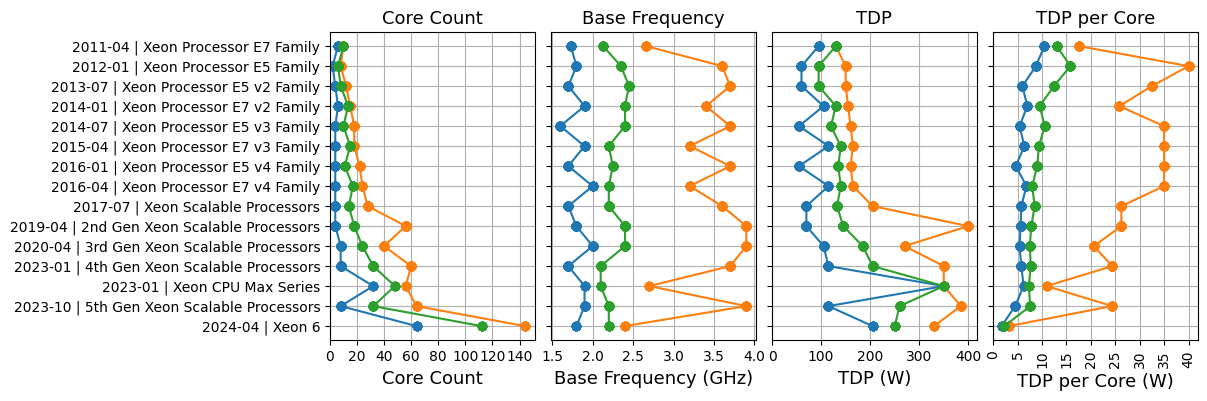

In [462]:
# Assuming key_collection, key_launch_date, key_core_count, key_base_freq, key_tdp, and key_tdp_per_core are defined.

figsize = (14, 4)
fontsize = 13

# Min / Max core count per collection
df_launch_year = df.groupby(key_collection)[key_launch_year_month].agg(['min', 'max'])
df_launch_year = df_launch_year.rename(columns={"min": "launch_min", "max": "launch_max"})

df_core_count = df.groupby(key_collection)[key_core_count].agg(['min', 'max', 'median'])
df_core_count = df_core_count.rename(columns={"min": "core_min", "max": "core_max", "median": "core_median"})

df_base_freq = df.groupby(key_collection)[key_base_freq].agg(['min', 'max', 'median'])
df_base_freq = df_base_freq.rename(columns={"min": "freq_min", "max": "freq_max", "median": "freq_median"})

df_tdp = df.groupby(key_collection)[key_tdp].agg(['min', 'max', 'median'])
df_tdp = df_tdp.rename(columns={"min": "tdp_min", "max": "tdp_max", "median": "tdp_median"})

df_tdp_per_core = df.groupby(key_collection)[key_tdp_per_core].agg(['min', 'max', 'median'])
df_tdp_per_core = df_tdp_per_core.rename(columns={"min": "tdp_core_min", "max": "tdp_core_max", "median": "tdp_core_median"})

plot_df = df_launch_year.join(df_core_count, on=key_collection)
plot_df = plot_df.join(df_base_freq, on=key_collection)
plot_df = plot_df.join(df_tdp, on=key_collection)
plot_df = plot_df.join(df_tdp_per_core, on=key_collection)
plot_df = plot_df.reset_index()
plot_df = pd.merge(plot_df, df[[key_collection, key_code_name]], on=key_collection, how='left')
plot_df["year_collection"] = plot_df["launch_min"].astype(str) + " | " + plot_df[key_collection]
plot_df = plot_df.sort_values(by='year_collection', ascending=False)

plt.close('all')
fig, axs = plt.subplots(1, 4, figsize=figsize, sharey=True, gridspec_kw = {'wspace':0.08})

# Adjust the subplot parameters to add space for the y-axis labels
plt.subplots_adjust(left=0.33, right=0.95)

# Core Count
axs[0].plot(plot_df['core_min'], plot_df['year_collection'], marker='o', label='Minimum')
axs[0].plot(plot_df['core_max'], plot_df['year_collection'], marker='o', label='Maximum')
axs[0].plot(plot_df['core_median'], plot_df['year_collection'], marker='o', label='Median')
axs[0].set_xlabel('Core Count', fontsize=fontsize)
axs[0].set_title('Core Count', fontsize=fontsize)
axs[0].grid(True)
axs[0].xaxis.set_major_locator(ticker.MultipleLocator(20))
axs[0].set_xlim(left=0)
axs[0].tick_params(axis='x', rotation=90)

# Base Frequency
axs[1].plot(plot_df['freq_min'], plot_df['year_collection'], marker='o', label='Minimum')
axs[1].plot(plot_df['freq_max'], plot_df['year_collection'], marker='o', label='Maximum')
axs[1].plot(plot_df['freq_median'], plot_df['year_collection'], marker='o', label='Median')
axs[1].set_xlabel('Base Frequency (GHz)', fontsize=fontsize)
axs[1].set_title('Base Frequency', fontsize=fontsize)
axs[1].grid(True)
axs[1].xaxis.set_major_locator(ticker.MultipleLocator(0.5))
# axs[1].set_xlim(left=0)
axs[1].tick_params(axis='x', rotation=90)


# TDP
axs[2].plot(plot_df['tdp_min'], plot_df['year_collection'], marker='o', label='Minimum')
axs[2].plot(plot_df['tdp_max'], plot_df['year_collection'], marker='o', label='Maximum')
axs[2].plot(plot_df['tdp_median'], plot_df['year_collection'], marker='o', label='Median')
axs[2].set_xlabel('TDP (W)', fontsize=fontsize)
axs[2].set_title('TDP', fontsize=fontsize)
axs[2].grid(True)
axs[2].xaxis.set_major_locator(ticker.MultipleLocator(100))
axs[2].set_xlim(left=0)
axs[2].tick_params(axis='x', rotation=90)

# TDP per Core
axs[3].plot(plot_df['tdp_core_min'], plot_df['year_collection'], marker='o', label='Minimum')
axs[3].plot(plot_df['tdp_core_max'], plot_df['year_collection'], marker='o', label='Maximum')
axs[3].plot(plot_df['tdp_core_median'], plot_df['year_collection'], marker='o', label='Median')
axs[3].set_xlabel('TDP per Core (W)', fontsize=fontsize)
axs[3].set_title('TDP per Core', fontsize=fontsize)
axs[3].grid(True)
axs[3].xaxis.set_major_locator(ticker.MultipleLocator(5))
axs[3].set_xlim(left=0)
axs[3].tick_params(axis='x', rotation=90)

# Adjust y-axis label position
for ax in axs:
    ax.tick_params(axis='x', labelsize=fontsize)
    ax.tick_params(axis='y', labelsize=fontsize)
    ax.yaxis.set_tick_params(pad=300)  # Adjust the padding for better alignment
    for label in ax.get_yticklabels():
        label.set_horizontalalignment('left')

# Add a shared legend above the subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.64, 1.07), ncol=3, fontsize=fontsize)

fig.supylabel('Launch Start | CPU Collection', fontsize=fontsize, x=0.015)
fig.tight_layout()
fig.savefig("../figures/intel_xeon_evolution.pdf")
plt.show()


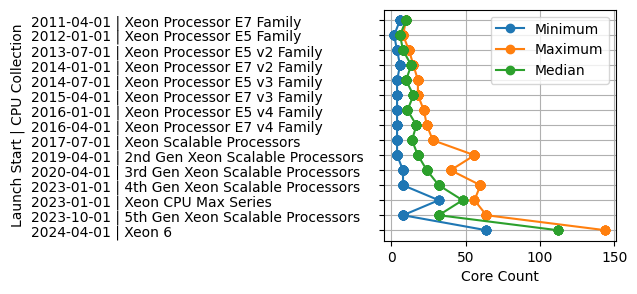

In [421]:
figsize = (3,3)

y_labelpad = 5

# Min / Max cour count per collection
df_launch_year = df.groupby(key_collection)[key_launch_date].agg(['min','max'])
df_launch_year = df_launch_year.rename(columns={"min":"launch_min", "max":"launch_max"})
df_core_count = df.groupby(key_collection)[key_core_count].agg(['min','max','median'])
df_core_count = df_core_count.rename(columns={"min":"core_min", "max":"core_max", "median":"core_median"})
plot_df = df_launch_year.join(df_core_count, on=key_collection)
plot_df = plot_df.reset_index()
plot_df = pd.merge(plot_df, df[[key_collection, key_code_name]], on=key_collection, how='left')
# plot_df = plot_df.join(df[[key_code_name]].drop_duplicates(), on=key_collection, how='left')
# Add this if you want to differentiate between microarchitectures in the different collections.
# plot_df["year_collection"] = plot_df["launch_min"].astype(str)+" | "+plot_df[key_collection] + " | " + plot_df[key_code_name]
plot_df["year_collection"] = plot_df["launch_min"].astype(str)+" | "+plot_df[key_collection]
plot_df = plot_df.sort_values(by='year_collection',ascending=False)

# print(df[key_collection].unique())

plt.close('all')
plt.figure(figsize=figsize)
plt.plot(plot_df['core_min'], plot_df['year_collection'], marker='o', label='Minimum')
plt.plot(plot_df['core_max'], plot_df['year_collection'], marker='o', label='Maximum')
plt.plot(plot_df['core_median'], plot_df['year_collection'], marker='o', label='Median')
plt.xlabel('Core Count')
plt.ylabel('Launch Start | CPU Collection', labelpad=y_labelpad)
plt.title('')
plt.yticks(rotation=0)
plt.gca().yaxis.set_tick_params(pad=250)  # Adjust the padding for better alignment
for label in plt.gca().get_yticklabels():
    label.set_horizontalalignment('left')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

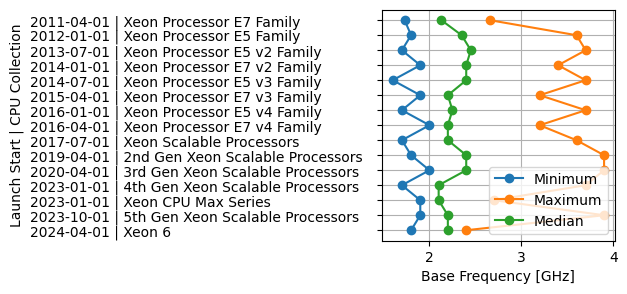

In [422]:
# Min / Max cour count per collection
df_base_frequency = df.groupby(key_collection)[key_base_freq].agg(['min','max','median'])
df_base_frequency = df_base_frequency.rename(columns={"min":"base_freq_min", "max":"base_freq_max", "median":"base_freq_median"})
# print(df_base_frequency)
plot_df = df_launch_year.join(df_base_frequency, on=key_collection)
plot_df = plot_df.reset_index()
plot_df["year_collection"] = plot_df["launch_min"].astype(str)+" | "+plot_df[key_collection]
plot_df = plot_df.sort_values(by='year_collection',ascending=False)

plt.close('all')
plt.figure(figsize=figsize)
plt.plot(plot_df['base_freq_min'], plot_df['year_collection'], marker='o', label='Minimum')
plt.plot(plot_df['base_freq_max'], plot_df['year_collection'], marker='o', label='Maximum')
plt.plot(plot_df['base_freq_median'], plot_df['year_collection'], marker='o', label='Median')
plt.xlabel('Base Frequency [GHz]')
plt.ylabel('Launch Start | CPU Collection')
plt.title('')
plt.yticks(rotation=0)
plt.gca().yaxis.set_tick_params(pad=250)  # Adjust the padding for better alignment
for label in plt.gca().get_yticklabels():
    label.set_horizontalalignment('left')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

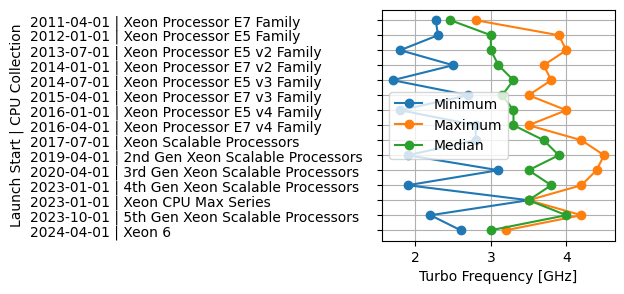

In [423]:
# Frequency
df_frequency = df.groupby(key_collection)[key_turbo_freq].agg(['min','max','median'])
df_frequency = df_frequency.rename(columns={"min":"freq_min", "max":"freq_max", "median":"freq_median"})
# print(df_frequency)
plot_df = df_launch_year.join(df_frequency, on=key_collection)
plot_df = plot_df.reset_index()
plot_df["year_collection"] = plot_df["launch_min"].astype(str)+" | "+plot_df[key_collection]
plot_df = plot_df.sort_values(by='year_collection',ascending=False)

plt.close('all')
plt.figure(figsize=figsize)
plt.plot(plot_df['freq_min'], plot_df['year_collection'], marker='o', label='Minimum')
plt.plot(plot_df['freq_max'], plot_df['year_collection'], marker='o', label='Maximum')
plt.plot(plot_df['freq_median'], plot_df['year_collection'], marker='o', label='Median')
plt.xlabel('Turbo Frequency [GHz]')
plt.ylabel('Launch Start | CPU Collection')
plt.title('')
plt.yticks(rotation=0)
plt.gca().yaxis.set_tick_params(pad=250)  # Adjust the padding for better alignment
for label in plt.gca().get_yticklabels():
    label.set_horizontalalignment('left')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

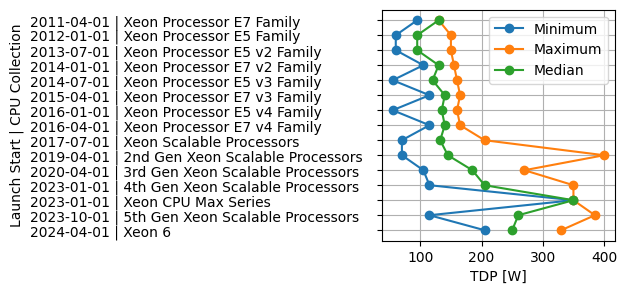

In [424]:
# TDP
df_tdp = df.groupby(key_collection)[key_tdp].agg(['min','max','median'])
df_tdp = df_tdp.rename(columns={"min":"tdp_min", "max":"tdp_max", "median":"tdp_median"})
# print(df_tdp)
plot_df = df_launch_year.join(df_tdp, on=key_collection)
plot_df = plot_df.reset_index()
plot_df["year_collection"] = plot_df["launch_min"].astype(str)+" | "+plot_df[key_collection]
plot_df = plot_df.sort_values(by='year_collection',ascending=False)

plt.close('all')
plt.figure(figsize=figsize)
plt.plot(plot_df['tdp_min'], plot_df['year_collection'], marker='o', label='Minimum')
plt.plot(plot_df['tdp_max'], plot_df['year_collection'], marker='o', label='Maximum')
plt.plot(plot_df['tdp_median'], plot_df['year_collection'], marker='o', label='Median')
plt.xlabel('TDP [W]')
plt.ylabel('Launch Start | CPU Collection')
plt.title('')
plt.yticks(rotation=0)
plt.gca().yaxis.set_tick_params(pad=250)  # Adjust the padding for better alignment
for label in plt.gca().get_yticklabels():
    label.set_horizontalalignment('left')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

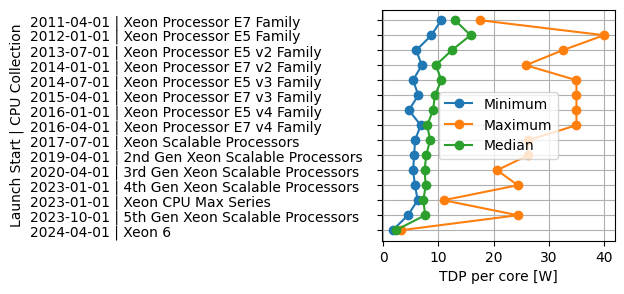

In [425]:
# TDP per core
df_tdp = df.groupby(key_collection)[key_tdp_per_core].agg(['min','max','median'])
df_tdp = df_tdp.rename(columns={"min":"tdp_min", "max":"tdp_max", "median":"tdp_median"})
# print(df_tdp)
plot_df = df_launch_year.join(df_tdp, on=key_collection)
plot_df = plot_df.reset_index()
plot_df["year_collection"] = plot_df["launch_min"].astype(str)+" | "+plot_df[key_collection]
plot_df = plot_df.sort_values(by='year_collection',ascending=False)

plt.close('all')
plt.figure(figsize=figsize)
plt.plot(plot_df['tdp_min'], plot_df['year_collection'], marker='o', label='Minimum')
plt.plot(plot_df['tdp_max'], plot_df['year_collection'], marker='o', label='Maximum')
plt.plot(plot_df['tdp_median'], plot_df['year_collection'], marker='o', label='Median')
plt.xlabel('TDP per core [W]')
plt.ylabel('Launch Start | CPU Collection')
plt.title('')
plt.yticks(rotation=0)
plt.gca().yaxis.set_tick_params(pad=250)  # Adjust the padding for better alignment
for label in plt.gca().get_yticklabels():
    label.set_horizontalalignment('left')
plt.legend()
plt.grid(True)
plt.show()
plt.close()

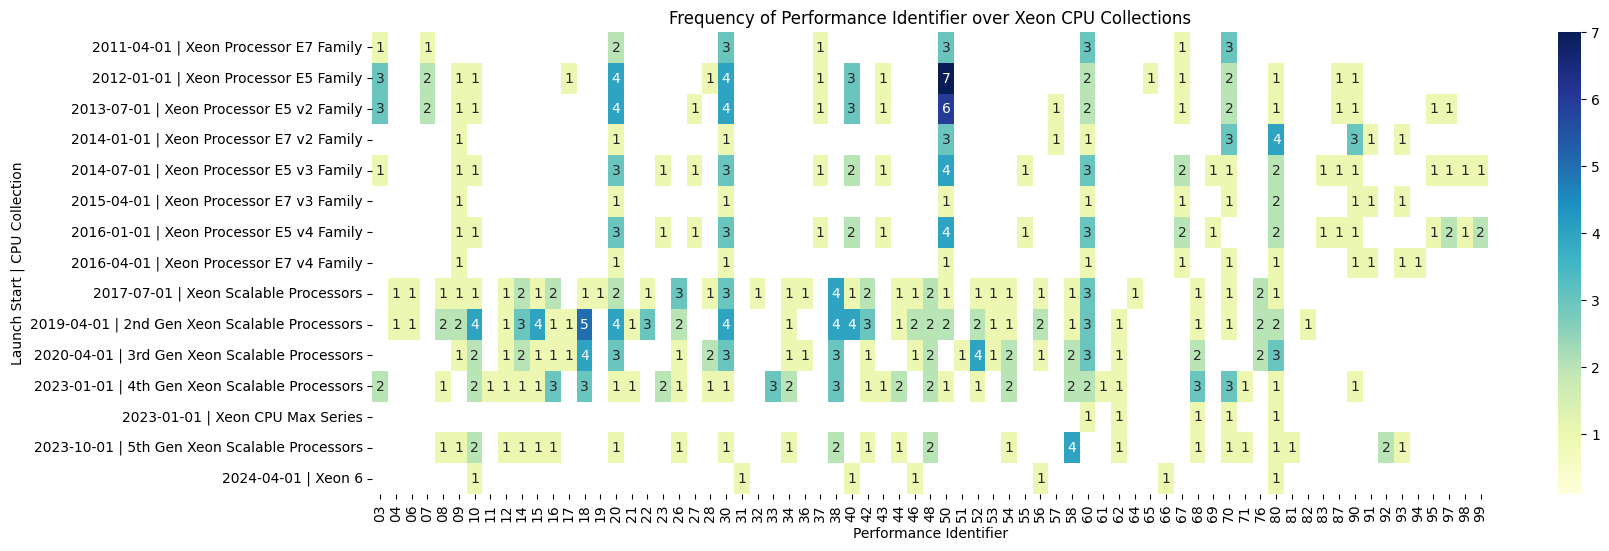

In [426]:
# df_launch_year = df_launch_year.reset_index()
df_plot = pd.merge(df, df_launch_year, on=key_collection, how='left')
df_plot["year_collection"] = df_plot["launch_min"] + " | " + df_plot[key_collection]

# Create a pivot table to count occurrences
pivot_table = df_plot.pivot_table(index="year_collection", columns=key_perf_id, aggfunc='size', fill_value=0)

# Define a custom color map
cmap = sns.color_palette("YlGnBu", as_cmap=True)
cmap.set_under('white')

# Plotting the heatmap
plt.figure(figsize=(18, 6))
ax = sns.heatmap(pivot_table, annot=True, fmt="d", cmap=cmap, cbar=True, mask=(pivot_table == 0), vmin=0.1)

# Set the x-axis labels to show all columns
ax.set_xticks([tick + 0.5 for tick in range(len(pivot_table.columns))])  # Center the ticks
ax.set_xticklabels(pivot_table.columns)

plt.title('Frequency of Performance Identifier over Xeon CPU Collections')
plt.xlabel('Performance Identifier')
plt.ylabel('Launch Start | CPU Collection')
plt.show()